In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os

In [2]:
data_dir = "filtered_data_ress_new"

sca_files = [f for f in os.listdir(data_dir) if ".sca" in f]
vec_files = [f for f in os.listdir(data_dir) if ".vec" in f]

# configuration_names = set([file_name.split("-N=")[0] for file_name in sca_files])
# configuration_names = ["RESS-IoT", "DQ", "MSDQ", "LoRaWAN"]
configuration_names = ["RESS-IoT"]

dfs = {name: {"SCA": {}, "VEC": {},} for name in configuration_names}

for file_name in sca_files:
    protocol = file_name.split("N=")[0][:-1]
    if "LoRa" in protocol:
        protocol = "LoRaWAN"
    
    if protocol not in configuration_names:
        continue
    
    print(file_name)
    df = pd.read_csv(f"{os.path.join(data_dir, file_name)}", dtype=str)
    
    if ".sca" in file_name:
        numNodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
        file_type = "SCA"
    elif ".vec" in file_name:
        numNodes = int(df.loc[df['attrname'] == "**.nrOfNodes"].attrvalue.iloc[0])
        file_type = "VEC"
    
    try:
        dfs[protocol][file_type][numNodes].append(df)
    except KeyError:
        dfs[protocol][file_type][numNodes] = [df]

for protocol in dfs:
    print(protocol)
    node_counts = list(dfs[protocol]["SCA"].keys())
    node_counts.sort()
    
    dfs[protocol]["SCA"] = {node_count: dfs[protocol]["SCA"][node_count] for node_count in node_counts}
    # dfs[protocol]["VEC"] = {node_count: dfs[protocol]["VEC"][node_count] for node_count in node_counts}

pd.set_option('display.max_rows', None)   

df = None

RESS-IoT-N=4000-#0.sca.csv
RESS-IoT-N=2000-#0.sca.csv
RESS-IoT-N=100-#0.sca.csv
RESS-IoT-N=1000-#0.sca.csv
RESS-IoT-N=10-#0.sca.csv
RESS-IoT-N=3000-#0.sca.csv
RESS-IoT


In [3]:
# Constants
p_rx = 25.74 / 1000 # W = J/s
p_tx = 389.4 / 1000 # W

def get_throughput_bytes_per_hour(df):
    # Throughput B / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    bytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * bytes_per_data_packet) / sim_time_hours

def get_throughput_kilobytes_per_hour(df):
    # Throughput kB / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    kilobytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8 / 1000
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * kilobytes_per_data_packet) / sim_time_hours

def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

def get_overhead_kilobytes(key, df):
    if "LoRa" in key:
        return get_overhead_bytes_LoRaMacClassA(df) / 8
    
    # Total bytes of overhead (Beacon, RTS, VCTS) or (ARS, FBP)
    possible_keys = [
        ('numARSPacketsSent', 'arsPacketLenBits'),
        ('numFBPPacketsSent', 'fbpPacketLenBits'),
        ('numRTSPacketsSent', 'rtsPacketLenBits'),
        ('numBeaconPacketsSent', 'beaconPacketLenBits'),
        ('numVCTSPacketsSent', 'vctsPacketLenBits'),
    ]
    
    overhead_bits = 0
    for key in possible_keys:
        try:
            total_num_packets = df.loc[df['name'] == key[0]].value.astype(int).sum()
            bits_per_packet = int(df.loc[df['name'] == key[1]].value.iloc[0])
            overhead_bits += (total_num_packets * bits_per_packet)
        except IndexError:
            pass

    return overhead_bits / 8 / 1000

def get_overhead_bytes_LoRaMacClassA(df):
    # total_num_ack_packets = df.loc[df['name'] == 'numACKPacketsSent'].value.astype(int).sum()
    # bits_per_ack_packet = int(df.loc[df['name'] == 'ackPacketLenBits'].value.iloc[0])
    # overhead_bits_ack = total_num_ack_packets * bits_per_ack_packet
    
    # Num packets involved in collisions
    # num_data_packets_sent = df.loc[df['name'] == 'numDataPacketsSent'].value.astype(int).sum()
    # num_data_packets_received = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])
    # num_data_packet_collisions = num_data_packets_sent - num_data_packets_received
    # bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0])
    # overhead_bits_data = num_data_packet_collisions * bits_per_data_packet

    # return overhead_bits_ack + overhead_bits_data
    return 0

def get_data_bytes(df):
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return bits_per_data_packet * num_data_packets / 8

def get_data_kilobytes(df):
    return get_data_bytes(df) / 1000

def get_avg_delay(df):
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])
    total_delay = float(df.loc[df['name'] == 'totalPacketDelay'].value.iloc[0])
    
    return total_delay / num_data_packets if num_data_packets > 0 else 0

def get_energy_satellite_DQ(df):
    num_rounds = int(df.loc[df['name'] == "numFBPPacketsSent"].value.iloc[0])
    
    # Sat always sends a FBP
    t_fbp = float(df.loc[df['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_rounds * p_tx * t_fbp
    
    # Sat always listens for all contention slots
    t_ars = float(df.loc[df['name'] == "arsPacketTime"].value.iloc[0])
    n_slots = int(df.loc[df['name'] == "numContentionSlots"].value.iloc[0])
    e_ars = num_rounds * p_rx * t_ars * n_slots
    
    # Sat only listens when a data packet will be sent len(dtq) != 0
    t_data = float(df.loc[df['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df.loc[df['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_rx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_node_DQ(df):
    num_rounds = int(df.loc[df['name'] == "numFBPPacketsSent"].value.iloc[0])
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])

    # Nodes always listen for FBP
    t_fbp = float(df.loc[df['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_nodes * num_rounds * p_rx * t_fbp
    
    # Nodes only send ARS when the constraints are met
    t_ars = float(df.loc[df['name'] == "arsPacketTime"].value.iloc[0])
    total_num_ars_packets_sent = df.loc[df['name'] == "numARSPacketsSent"].value.astype(int).sum()
    e_ars = total_num_ars_packets_sent * p_tx * t_ars
    
    # Only one or zero data packets can be sent each round
    t_data = float(df.loc[df['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df.loc[df['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_tx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_satellite_RESSIOT(df):
    num_rounds = int(df.loc[df['name'] == "numBeaconPacketsSent"].value.iloc[0])

    t_beacon = float(df.loc[df['name'] == "beaconPacketTime"].value.iloc[0])
    w_rx = float(df.loc[df['name'] == "wrx"].value.iloc[0])
    e_rp_sat = num_rounds * ((p_tx * t_beacon) + (p_rx * w_rx))
    
    t_vcts = float(df.loc[df['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df.loc[df['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df.loc[df['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_sat = (num_rounds * p_tx * t_vcts) + (num_data_packets * p_rx * t_data)
    
    return e_rp_sat + e_tp_sat

def get_energy_node_RESSIOT(df):   
    num_rounds = int(df.loc[df['name'] == "numBeaconPacketsSent"].value.iloc[0])
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])

    t_beacon = float(df.loc[df['name'] == "beaconPacketTime"].value.iloc[0])
    t_rts = float(df.loc[df['name'] == "rtsPacketTime"].value.iloc[0])
    total_num_rts_packets_sent = df.loc[df['name'] == "numRTSPacketsSent"].value.astype(int).sum()
    e_rp_nodes = (num_nodes * num_rounds * p_rx * t_beacon) + (total_num_rts_packets_sent * p_tx * t_rts)
    
    t_vcts = float(df.loc[df['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df.loc[df['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df.loc[df['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_tp_nodes = (num_rounds * num_nodes * p_rx * t_vcts) + (num_data_packets * p_tx * t_data)

    return e_rp_nodes + e_tp_nodes

def get_energy_satellite_LoRaMacClassA(df):
    sim_time_seconds = float(df.loc[df['name'] == 'simulated time'].value.iloc[0])
    t_ack = float(df.loc[df['name'] == "ackPacketTime"].value.iloc[0])
    num_acks = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0]) # num acks is the same as num data packets received
    t_listening = sim_time_seconds - (t_ack * num_acks)
    num_data_packets_received = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    # return (p_rx * t_listening) + (p_tx * t_ack * num_data_packets_received) # Confirmed energy model
    return (p_rx * sim_time_seconds) # unconfirmed energy model

def get_energy_node_LoRaMacClassA(df):
    t_ack = float(df.loc[df['name'] == "ackPacketTime"].value.iloc[0])
    num_data_packets_received = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])
    t_data = float(df.loc[df['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets_sent = df.loc[df['name'] == 'numDataPacketsSent'].value.astype(int).sum()
    
    # return (p_rx * t_ack * num_data_packets_received) + (p_tx * t_data * num_data_packets_sent) # Confirmed energy model
    return (p_tx * t_data * num_data_packets_sent) # unconfirmed energy model

def get_avg_energy_efficiency_node(key, df):
    if key == "RESS-IoT": 
        e_nodes = get_energy_node_RESSIOT(df)
    elif "DQ" in key:
        e_nodes = get_energy_node_DQ(df)
    elif "LoRa" in key:
        e_nodes = get_energy_node_LoRaMacClassA(df)

    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    
    return (get_data_bytes(df) / num_nodes ) / (e_nodes / num_nodes)
    
def get_energy_efficiency_satellite(key, df):
    if key == "RESS-IoT": 
        e_sat = get_energy_satellite_RESSIOT(df)
    elif "DQ" in key:
        e_sat = get_energy_satellite_DQ(df)
    elif "LoRa" in key:
        e_sat = get_energy_satellite_LoRaMacClassA(df)
    
    return get_data_bytes(df) / e_sat

def get_energy_efficiency_network(key, df):
    if key == "RESS-IoT": 
        e_network = get_energy_satellite_RESSIOT(df) + get_energy_node_RESSIOT(df)
    elif "DQ" in key:
        e_network = get_energy_satellite_DQ(df) + get_energy_node_DQ(df)
    elif "LoRa" in key:
        e_network = get_energy_satellite_LoRaMacClassA(df) + get_energy_node_LoRaMacClassA(df)
    
    return get_data_bytes(df) / e_network

# Battery capacities
E_b_sat = 34632 # Joules
E_b_node = 2160 # Joules

def get_survivability_sat(key, df):
    sim_time_seconds = float(df.loc[df['name'] == 'simulated time'].value.iloc[0])
    if key == "RESS-IoT": 
        e_sat = get_energy_satellite_RESSIOT(df)
    elif "DQ" in key:
        e_sat = get_energy_satellite_DQ(df)
    elif "LoRa" in key:
        e_sat = get_energy_satellite_LoRaMacClassA(df)

    P_c_sat = e_sat / sim_time_seconds
    L = E_b_sat / P_c_sat
    return L / 60 / 60 # hours

def get_survivability_node(key, df):
    sim_time_seconds = float(df.loc[df['name'] == 'simulated time'].value.iloc[0])
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    if key == "RESS-IoT": 
        e_nodes = get_energy_node_RESSIOT(df) # Joules
    elif "DQ" in key:
        e_nodes = get_energy_node_DQ(df) # Joules
    elif "LoRa" in key:
        e_nodes = get_energy_node_LoRaMacClassA(df) # Joules

    P_c_node = e_nodes / num_nodes / sim_time_seconds # Watts
    L = E_b_node / P_c_node # Seconds
    return L / 60 / 60 # hours


In [4]:
metrics = {}

for protocol in dfs:
    print(f"Working on {protocol}...")
    
    metrics[protocol] = {}
    
    for node_count in dfs[protocol]["SCA"]:
        metrics[protocol][node_count] = {
            "Average Delay [seconds]": [],
            "Jain Fairness Index": [],
            "Throughput [kilobytes / hour]": [],
            "Overhead": [],
            "Data": [],
            "Satellite Energy Efficiency [bytes / joule]": [],
            "Average Energy Efficiency per Node [bytes / joule]": [],
            "Network Energy Efficiency [bytes / joule]": [],
            "Node Survivability [hours]": [],
            "Satellite Survivability [hours]": [],
        }
        
        for df_sca in dfs[protocol]["SCA"][node_count]:
            metrics[protocol][node_count]["Average Delay [seconds]"].append(get_avg_delay(df_sca))
            metrics[protocol][node_count]["Jain Fairness Index"].append(get_jfi(df_sca))
            metrics[protocol][node_count]["Throughput [kilobytes / hour]"].append(get_throughput_kilobytes_per_hour(df_sca))
            metrics[protocol][node_count]["Overhead"].append(get_overhead_kilobytes(protocol, df_sca))
            metrics[protocol][node_count]["Data"].append(get_data_kilobytes(df_sca))
            metrics[protocol][node_count]["Satellite Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_satellite(protocol, df_sca))
            metrics[protocol][node_count]["Average Energy Efficiency per Node [bytes / joule]"].append(get_avg_energy_efficiency_node(protocol, df_sca))
            metrics[protocol][node_count]["Network Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_network(protocol, df_sca))
            metrics[protocol][node_count]["Node Survivability [hours]"].append(get_survivability_node(protocol, df_sca))
            metrics[protocol][node_count]["Satellite Survivability [hours]"].append(get_survivability_sat(protocol, df_sca))


Working on RESS-IoT...


Satellite Survivability [hours]


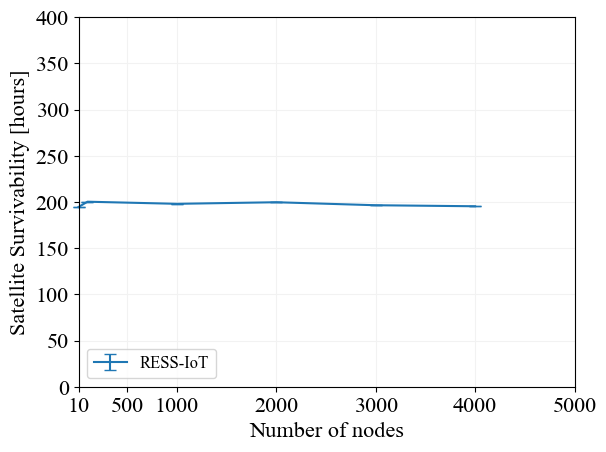

Node Survivability [hours]


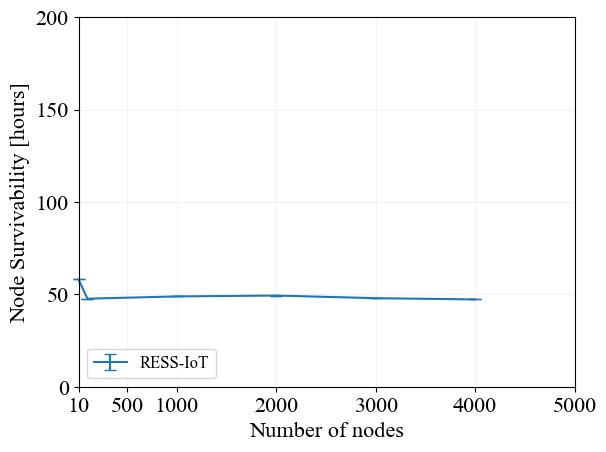

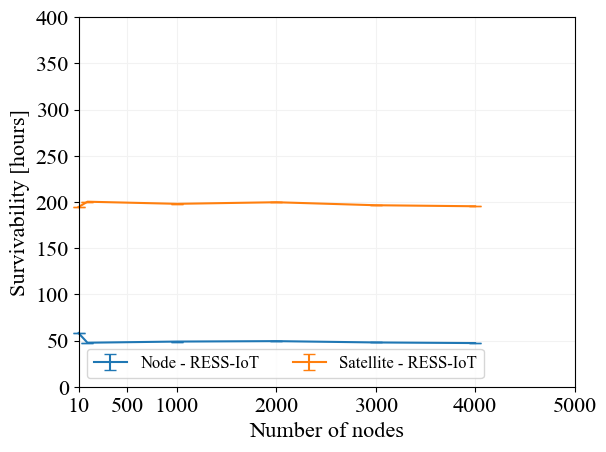

Satellite Energy Efficiency [bytes / joule]


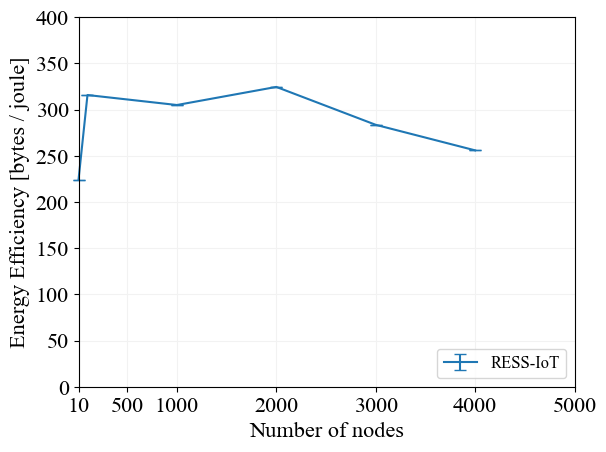

Average Energy Efficiency per Node [bytes / joule]


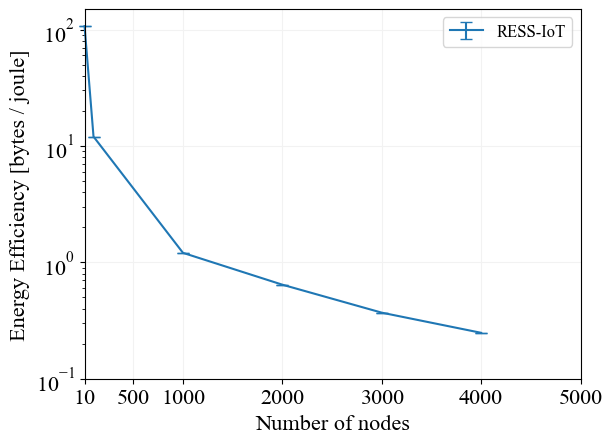

Network Energy Efficiency [bytes / joule]


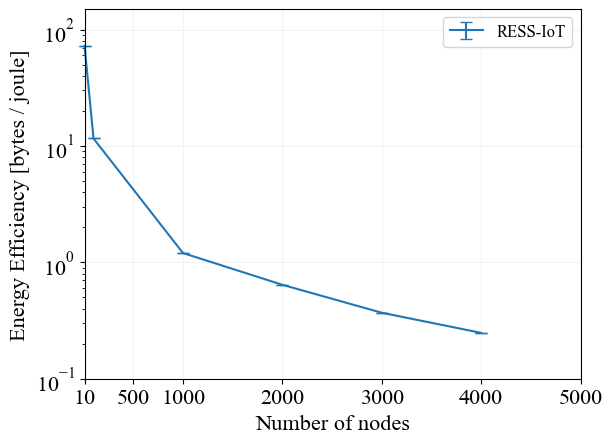

Jain Fairness Index


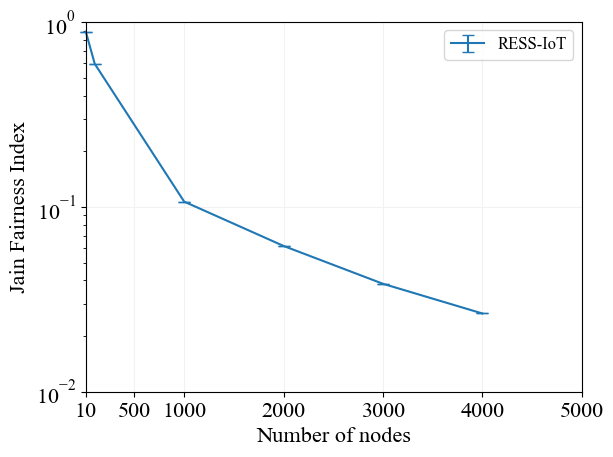

Throughput kilobytes / hour


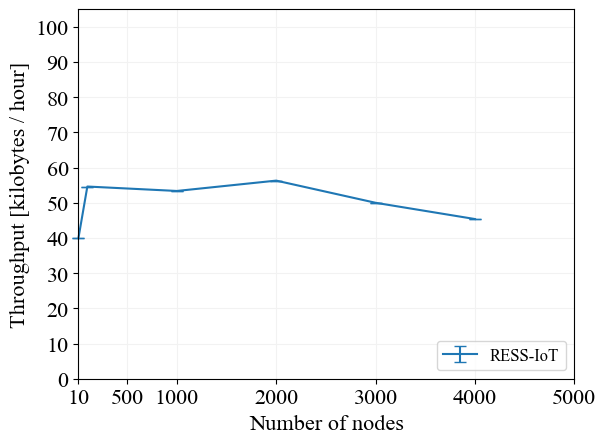

Overhead and data [kilobytes]


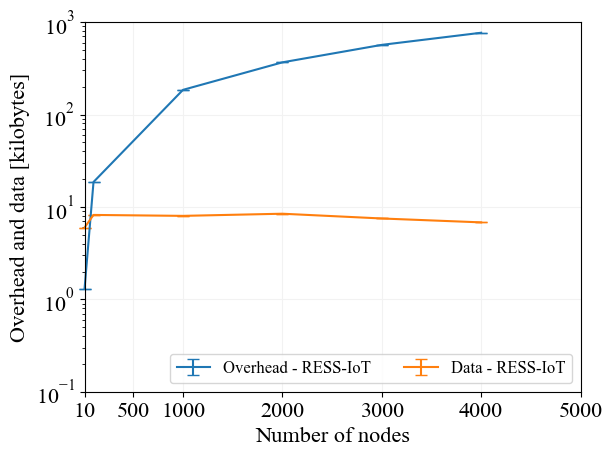

Average Delay [seconds]


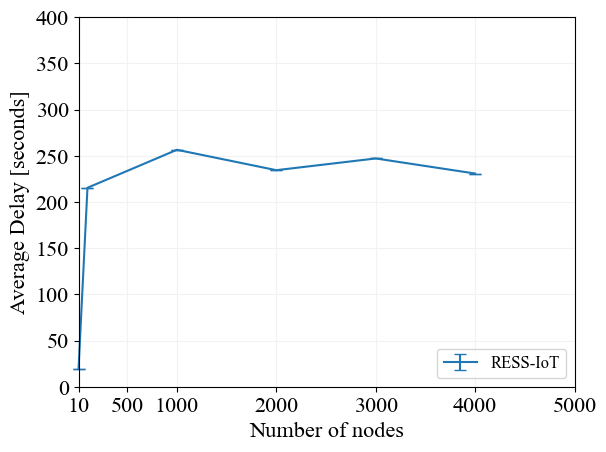

In [5]:
plt.rcParams.update({'font.size': 16})
plt.rc('legend', fontsize=12)
plt.rcParams.update({'font.family': 'Times New Roman'})

output_dir = "output_graphs/performance_metrics"

def plot_runs(metric_names, label, ylims, is_log=False, show_metric_name=False, legend_pos="lower left"):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for metric in metric_names:
        for protocol in dfs:
            x = list(metrics[protocol].keys())
            ys = [metrics[protocol][node_count][metric] for node_count in x]
            y = [np.average(y) for y in ys]
            yerr = [np.std(y) for y in ys]

            # This avoids issues when the metric falls to 0 for log graphs
            if is_log:
                y = [y_p for y_p in y if y_p > 0]
                yerr = yerr[:len(y)]
                x = x[:len(y)]

            key_label = protocol if not show_metric_name else f"{metric} - {protocol}"
            if "Survivability" in key_label:
                key_label = f"{metric.split(' ')[0]} - {protocol}"
            
            plt.errorbar(x, y, yerr=yerr, label=key_label, capsize=4, clip_on=False)
    
    if "Energy Efficiency" in label:
        y_label = "Energy Efficiency [bytes / joule]"
    else:
        y_label = label
    plt.ylabel(y_label)
    plt.xlabel("Number of nodes")
    if len(metric_names) > 1:
        plt.legend(loc=legend_pos, ncol=2)
    else:
        plt.legend(loc=legend_pos, ncol=1)
    plt.grid(linestyle='-', color='0.95')
    
    if is_log:
        plt.yscale("log")  
    
    plt.ylim(ylims[0], ylims[1])
    plt.xlim(10, 5000)
    
    x_ticks = np.append(ax.get_xticks()[1:], 10)
    x_ticks = np.append(x_ticks, 500)
    ax.set_xticks(x_ticks)

    if not is_log:
        ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 50))
        if len(ax.get_yticks()) < 5:
            ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 10))

    plt.savefig(
        os.path.join(output_dir, f"{label.replace(' ', '_').replace('/', '_')}.pdf"),
        format="pdf",
        bbox_inches='tight'
    )
    plt.show()

print("Satellite Survivability [hours]")
metric = "Satellite Survivability [hours]"
plot_runs([metric], metric, [0, 400], False)

print("Node Survivability [hours]")
metric = "Node Survivability [hours]"
plot_runs([metric], metric, [0, 200], False)

plot_runs(["Node Survivability [hours]", "Satellite Survivability [hours]"], "Survivability [hours]", [0, 400], False, True)

print("Satellite Energy Efficiency [bytes / joule]")
metric = "Satellite Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0, 400], False, legend_pos="lower right")

print("Average Energy Efficiency per Node [bytes / joule]")
metric = "Average Energy Efficiency per Node [bytes / joule]"
plot_runs([metric], metric, [0.1, 150], True, legend_pos="upper right")

print("Network Energy Efficiency [bytes / joule]")
metric = "Network Energy Efficiency [bytes / joule]"
plot_runs([metric], metric, [0.1, 150], True, legend_pos="upper right")

print("Jain Fairness Index")
metric = "Jain Fairness Index"
plot_runs([metric], metric, [0.01, 1], True, legend_pos="upper right")

print("Throughput kilobytes / hour")
metric = "Throughput [kilobytes / hour]"
plot_runs([metric], metric, [0, 105], legend_pos="lower right")

print("Overhead and data [kilobytes]")
plot_runs(["Overhead", "Data"], "Overhead and data [kilobytes]", [0.1, 1000], True, True, legend_pos="lower right")

print("Average Delay [seconds]")
metric = "Average Delay [seconds]"
plot_runs([metric], metric, [0, 400], legend_pos="lower right")

[[213.94061130760352, 0.17548636161706122, 36.239999999999995, 0.016946314678465333, 52.23831431118126, 204.36105136753702, 0.0011523181293552822, 0.004257325999288177], [150.75043836977534, 0.5443305627369567, 37.12, 0.013274554366258972, 158.36712739672754, 140.64658307286996, 0.07418397626112759, 0.002543059126098019], [597.4306054649621, 3.3079979305455973, 85.61999999999999, 0.024605889489385295, 417.01996791227924, 241.5862126221614, 0.1238850346878097, 0.0036698682683131666], [0.0, 0.0, 0.0, 0.0, 116.14587551750489, 373.73737373737373, 0, 0]]
['RESS-IoT', 'DQ', 'MSDQ', 'LoRaWAN']


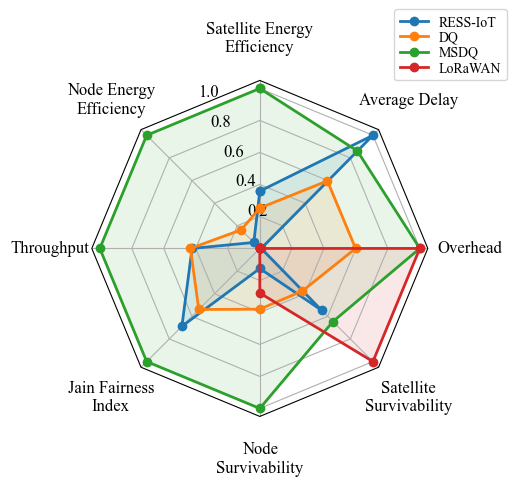

In [34]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

plt.rcParams.update({'font.size': 12})
plt.rc('legend', fontsize=12)
plt.rcParams.update({'font.family': 'Times New Roman'})

spoke_labels = [
    "Satellite Energy Efficiency [bytes / joule]",
    "Average Energy Efficiency per Node [bytes / joule]",
    "Throughput [kilobytes / hour]",
    "Jain Fairness Index",
    "Node Survivability [hours]",
    "Satellite Survivability [hours]",
    "Overhead",
    "Average Delay [seconds]",
]

labels = []

data = []
for protocol in dfs:
    # Uncomment to remove LoRa
    # if "LoRa" in protocol:
    #     continue
    labels.append(protocol)
    protocol_data = []
    for metric in spoke_labels:
        ys = metrics[protocol][5000][metric]
        y = np.average(ys)
 
        # Fix for LoRa having no overhead and no delay at 5k nodes because it has 0 kb/hr of throughput
        if metric == "Overhead" or metric == "Average Delay [seconds]":
            y = 1/y if y > 0 else 0
        
        protocol_data.append(y)
    data.append(protocol_data)
print(data)
print(labels)

for i in range(len(data[0])):
    metric_upper_bound = max([protocol_data[i] for protocol_data in data])
    for j in range(len(data)):
        if spoke_labels[i] == "Overhead" and data[j][i] == 0: # FIX for LoRa having no overhead
            data[j][i] = metric_upper_bound / metric_upper_bound 
        else:
            data[j][i] = data[j][i] / metric_upper_bound

theta = radar_factory(len(spoke_labels), frame='polygon')

fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.15)
ax.tick_params(pad=20)

colors = ['C0', 'C1', 'C2', 'C3']
# Plot the four cases from the example data on separate axes
# for ax, (title, case_data) in zip(axs.flat, data):
ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_title("test", weight='bold', size='medium', position=(0.5, 1.1),
#              horizontalalignment='center', verticalalignment='center')
for d, color in zip(data, colors):
    ax.plot(theta, d, 'o', ls='-', color=color, linewidth=2.0)
    ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')

spoke_labels = [
    "Satellite Energy\nEfficiency",
    "Node Energy\nEfficiency",
    "Throughput",
    "Jain Fairness\nIndex",
    "Node\nSurvivability",
    "Satellite\nSurvivability",
    "Overhead",
    "Average Delay",
]
ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
legend = ax.legend(labels, loc=(0.9, 1.0),
                          labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.savefig(
    os.path.join(output_dir, "relative_scoring_spider_graph.pdf"),
    format="pdf",
    bbox_inches='tight'
)

plt.show()

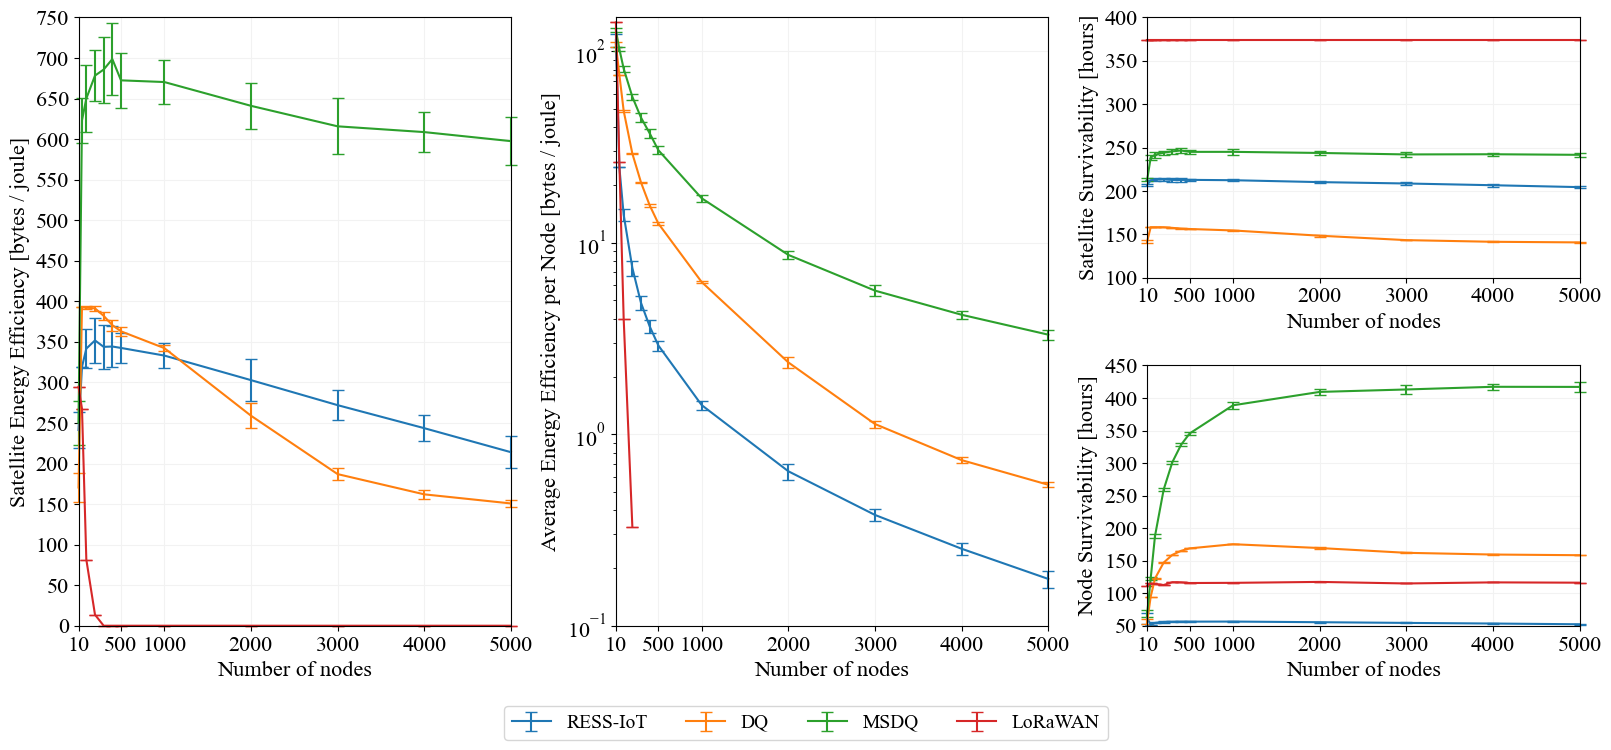

In [38]:
plt.rcParams.update({'font.size': 16})
plt.rc('legend', fontsize=14)
plt.rcParams.update({'font.family': 'Times New Roman'})

output_dir = "output_graphs/performance_metrics"

def plot_runs(ax, metric_names, label, ylims, is_log=False, show_metric_name=False, legend_pos="lower left"):
    for metric in metric_names:
        for protocol in dfs:
            x = list(metrics[protocol].keys())
            ys = [metrics[protocol][node_count][metric] for node_count in x]
            y = [np.average(y) for y in ys]
            yerr = [np.std(y) for y in ys]

            # This avoids issues when the metric falls to 0 for log graphs
            if is_log:
                y = [y_p for y_p in y if y_p > 0]
                yerr = yerr[:len(y)]
                x = x[:len(y)]

            key_label = protocol if not show_metric_name else f"{metric} - {protocol}"
            if "Survivability" in key_label:
                key_label = f"{metric.split(' ')[0]} - {protocol}"

            plt.errorbar(x, y, yerr=yerr, label=key_label, capsize=4, clip_on=False)

    plt.ylabel(label)
    plt.xlabel("Number of nodes")
    plt.grid(linestyle='-', color='0.95')

    if is_log:
        plt.yscale("log")

    plt.ylim(ylims[0], ylims[1])
    plt.xlim(10, 5000)

    x_ticks = np.append(ax.get_xticks()[1:], 10)
    x_ticks = np.append(x_ticks, 500)
    ax.set_xticks(x_ticks)

    if not is_log:
        ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 50))
        if len(ax.get_yticks()) < 5:
            ax.set_yticks(np.arange(ylims[0], ylims[1]+1, 25))


fig = plt.figure(figsize=(16, 12), dpi=100, constrained_layout=True)
grid = fig.add_gridspec(4, 6)

ax1 = fig.add_subplot(grid[0:2, 0:2])
metric = "Satellite Energy Efficiency [bytes / joule]"
plot_runs(ax1, [metric], metric, [0, 750], False, legend_pos="lower right")

ax2 = fig.add_subplot(grid[0:2, 2:4])
metric = "Average Energy Efficiency per Node [bytes / joule]"
plot_runs(ax2, [metric], metric, [0.1, 150], True, legend_pos="upper right")

ax3 = fig.add_subplot(grid[0, 4:6])
metric = "Satellite Survivability [hours]"
plot_runs(ax3, [metric], "Satellite Survivability [hours]", [100, 400], False)

ax4 = fig.add_subplot(grid[1, 4:6])
metric = "Node Survivability [hours]"
plot_runs(ax4, [metric], metric, [50, 450], False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="outside lower center", ncol=len(by_label), bbox_to_anchor=(0.5,0.38))

plt.savefig(
    os.path.join(output_dir, "energy_metrics.pdf"),
    format="pdf",
    bbox_inches='tight'
)

plt.show()